# Google Trend Prediction v2: Enhancing Input Space

This notebook compares the performances of vanilla fully connected neural network, one that uses one-hot encodding and one that uses embedding. I have used the Google Trend results for the word diet as my toy example.

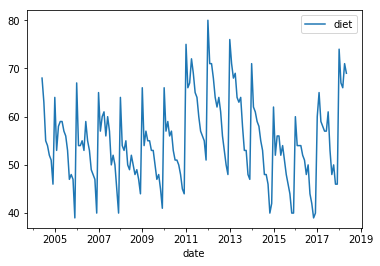

In [1]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

keyword = 'diet'
pytrend = TrendReq(hl='de-CH')

# To dowloand it from internet, I have saved a local copy 
#pytrend.build_payload(kw_list=[keyword], timeframe='all')
#df = pytrend.interest_over_time()

df = pd.read_csv('./diet.csv', names=['date', 'diet'])
df = df[2:]
df.diet = df.diet.astype('int64')
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df2 = df[5:]

df2.plot()
plt.show()

# Preprocessing

Each version of the NN requires a different input space. Hence, I will generate a different input for each model. The one below is for the vanilla NN.

In [2]:
import pandas as pd
import numpy as np
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lag = 5
pre_raw = df2.copy()

for i in range(1, lag+1):
    name = 'lag'+str(i)
    pre_raw.insert(loc=i, column = name, value = pre_raw.diet.shift(i))

pre_raw.insert(loc=lag+1, column= 'nextDay', value= pre_raw.diet.shift(-1))
pre_raw = pre_raw[lag:]
pre_raw = pre_raw[:-1]
pre_raw = pre_raw.reset_index(drop=True)
raw = pre_raw.iloc[:,0:lag+2].copy()
raw = [(torch.from_numpy(raw.iloc[i,0:lag+1].values), 
        torch.from_numpy(raw.iloc[i,[lag+1]].values)) for i in range(len(raw))]

For the rest of the models, I will enhance the input space by teaching seasons to the model. The seasons function returns a value based on the month of the trend. For example, 0 corresponds to winter, 1 corresponds to spring, and so on. 

In [3]:
def seasons(date):
    #seasons = {12:'winter', 1: 'winter', 2: 'winter',
    #       3: 'spring', 4: 'spring', 5: 'spring',
    #      6:'summer', 7:'summer', 8:'summer',
    #      9:'fall', 10:'fall', 11:'fall'}
    seasons = {12: 0, 1: 0, 2: 0,
           3: 1, 4: 1, 5: 1,
          6:2, 7:2, 8:2,
          9:3, 10:3, 11:3}
    
    return(seasons[date.to_pydatetime().month])

df3 = df2.copy()
df3.insert(loc=1, column='season', value = [seasons(ind) for ind in df3.index])

The below prepocessing is for the model using embedding. 

In [4]:
lag = 5
pre_raw = df3.copy()

for i in range(1, lag+1):
    name = 'lag'+str(i)
    pre_raw.insert(loc=i, column = name, value = pre_raw.diet.shift(i))

pre_raw.insert(loc=lag+1, column= 'nextDay', value= pre_raw.diet.shift(-1))
pre_raw = pre_raw[lag:]
pre_raw = pre_raw[:-1]
pre_raw = pre_raw.reset_index(drop=True)
pre_raw = pre_raw.iloc[:,np.argsort([0, 1, 2, 3, 4, 5, 7, 6])]
raw2 = pre_raw.iloc[:,0:lag+3].copy()
raw2 = [(torch.from_numpy(raw2.iloc[i,0:lag+2].values), 
        torch.from_numpy(raw2.iloc[i,[lag+2]].values)) for i in range(len(raw2))]

Below code is for the model using one-hot encodding.

In [5]:
lag = 5
pre_raw = df3.copy()

for i in range(1, lag+1):
    name = 'lag'+str(i)
    pre_raw.insert(loc=i, column = name, value = pre_raw.diet.shift(i))

pre_raw.insert(loc=lag+1, column= 'nextDay', value= pre_raw.diet.shift(-1))
pre_raw = pre_raw[lag:]
pre_raw = pre_raw[:-1]
pre_raw = pre_raw.reset_index(drop=True)
pre_raw['winter'] = np.zeros(len(pre_raw))
pre_raw['spring'] = np.zeros(len(pre_raw))
pre_raw['summer'] = np.zeros(len(pre_raw))
pre_raw['fall'] = np.zeros(len(pre_raw))
for i in range(len(pre_raw)):
    row = pre_raw.season.iloc[i]
    if row == 0:
        pre_raw.winter.iloc[i] = 1
    elif row == 1:
        pre_raw.spring.iloc[i] = 1
    elif row == 2:
        pre_raw.summer.iloc[i] = 1
    else:
        pre_raw.fall.iloc[i] = 1
pre_raw= pre_raw.drop(labels=['season'], axis = 1)
pre_raw = pre_raw.iloc[:,np.argsort([0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9])]
raw3 = pre_raw.iloc[:,0:lag+6].copy()
raw3 = [(torch.from_numpy(raw3.iloc[i,0:lag+5].values), 
        torch.from_numpy(raw3.iloc[i,[lag+5]].values)) for i in range(len(raw3))]

C:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Models

The script for the fully connected network in this motebook is more flexible allowing the user to define as many layers as they want using the lin_size paramater. All the models use fully connected networks. The only difference for embeddings is, pyTorch's embedding function is used to look up values corresponding to the season and these values are adjusted at each iteration of the algorithm. 

To compare the performance of these models, I will repeat training and prediction 50 times to minimize the impact of random initializations on the results.

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, lin_size=[6, 20, 15, 1]):
        super().__init__()
        self.lins = nn.ModuleList([nn.Linear(lin_size[x], lin_size[x+1]) 
                                   for x,_ in enumerate(lin_size) if x < len(lin_size)-2])
        self.out = nn.Linear(lin_size[-2], lin_size[-1])
        
    def forward(self, x):
        for l in self.lins:
            x = F.relu(l(x))
        
        x = self.out(x)
        return x

In [7]:
class SimpleNetwithEmbed(nn.Module):
    def __init__(self, cont_idx, cat_idx, embed_detail, lin_size):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in embed_detail])
        for emb in self.embs:
            x = emb.weight.data
            sc = 2/(x.size(1)+1)
            x.uniform_(-sc, sc)
    
        self.lins = nn.ModuleList([nn.Linear(lin_size[x], lin_size[x+1]) 
                                   for x,_ in enumerate(lin_size) if x < len(lin_size)-2])
        self.out = nn.Linear(lin_size[-2], lin_size[-1])
        
        self.bn = nn.BatchNorm1d(len(cont_idx))
        self.cont_idx = cont_idx
        self.cat_idx = cat_idx
                
    def forward(self, x):
        x_ = x[:,self.cont_idx]
        x_ = self.bn(x_)
        x_cat = x[:,self.cat_idx]
        
        embs = (e(x_cat[:,i].type(torch.long)) for i,e in enumerate(self.embs))
        for e in embs:
            x_ = torch.cat([x_, e], 1)
        
        for l in self.lins:
            x_ = F.relu(l(x_))
        
        x_ = self.out(x_)
        return x_

The embeddings are initialized with values approximately between -1 and 1 (this range changes based on the dimensions of the embedding) and Google trend values are disproportionately larger compared to the embeddings, hence these values need to be batch normalized for gradients of the model to allow learning from the data set. 

In [8]:
def experiment(lag, model, train_loader, test_loader, opt, loss):
    # train
    for epoch in range(num_epochs):
        running_loss = 0.0
        tot = 0
        for i, (x, y) in enumerate(train_loader):
            x = x.float().to(device)
            y = y.float().to(device)

            # Forward pass
            output = model(x)
            l = loss(output, y)

            # Backward and optimize
            opt.zero_grad()
            l.backward()
            opt.step()
        
            running_loss += l.item()
            tot += 1
        #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/tot  ))

    names = ['diet']
    names.extend(['lag'+str(i) for i in range(1, lag+1)])
    names.extend(['prediction', 'actual'])

    result = pd.DataFrame(columns=names)
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for x, y in test_loader:
            x = x.float().to(device)
            local = x.cpu().numpy()
            y = y.float().to(device)            
            outputs = model(x)

            temp = pd.DataFrame(columns=names)
            temp['diet'] = local[:,0]
            for i in range(1, lag+1):
                name = 'lag'+str(i)
                temp[name] = local[:,i]

            temp['actual'] = y.cpu().numpy()
            temp['prediction'] = outputs.cpu().numpy()
            result = result.append(temp)
    return(result)        

In [23]:
num_epochs=20
batch_size=25
learning_rate=0.04
repeat = 50
results = pd.DataFrame(columns=['Vanilla', 'OneHot', 'Embedding'])
train_loader = data.DataLoader(dataset=raw[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw[120:170], batch_size=1, shuffle=False)

for i in range(repeat):
    temp = pd.DataFrame(columns=['Vanilla', 'OneHot', 'Embedding'])
    
    net = SimpleNet(lin_size=[6, 20, 20, 1]).to(device)
    opt=optim.Adam(net.parameters(), lr=learning_rate)
    loss=F.mse_loss
    
    out = experiment(lag= lag, 
               model=net, 
               train_loader=train_loader, 
               test_loader=test_loader, 
               opt=opt, 
               loss=loss)
    
    temp.loc[0] = [np.mean(abs(out.prediction - out.actual)), None, None]
    results = results.append(temp)

results = results.reset_index(drop=True);

In [24]:
num_epochs=20
batch_size=25
learning_rate=0.04
train_loader = data.DataLoader(dataset=raw2[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw2[120:170], batch_size=1, shuffle=False)

for i in range(repeat):
    temp = pd.DataFrame(columns=['Vanilla', 'OneHot', 'Embedding'])
    
    net = SimpleNetwithEmbed(cont_idx=list(range(0,6)), 
                          cat_idx=[6], 
                          embed_detail=[(4,2)], 
                          lin_size=[8, 20, 20, 1]).to(device)
    opt=optim.Adam(net.parameters(), lr=learning_rate)
    loss=F.mse_loss
    
    out = experiment(lag= lag, 
               model=net, 
               train_loader=train_loader, 
               test_loader=test_loader, 
               opt=opt, 
               loss=loss)
    
    results.Embedding[i] = np.mean(abs(out.prediction - out.actual))

In [25]:
num_epochs=20
batch_size=25
learning_rate=0.04
train_loader = data.DataLoader(dataset=raw3[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw3[120:170], batch_size=1, shuffle=False)

for i in range(repeat):
    temp = pd.DataFrame(columns=['Vanilla', 'OneHot', 'Embedding'])
    
    net = SimpleNet(lin_size=[10, 20, 20, 1]).to(device)
    opt=optim.Adam(net.parameters(), lr=learning_rate)
    loss=F.mse_loss
    
    out = experiment(lag= lag, 
               model=net, 
               train_loader=train_loader, 
               test_loader=test_loader, 
               opt=opt, 
               loss=loss)
    
    results.OneHot[i] = np.mean(abs(out.prediction - out.actual))

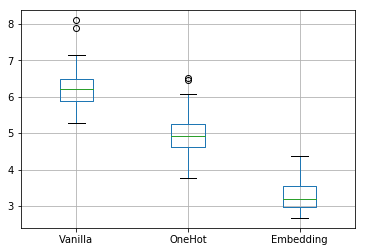

In [26]:
results.boxplot()
plt.show()

In [27]:
import scipy.stats
print(scipy.stats.ttest_ind(results.Vanilla, results.OneHot))
print(scipy.stats.ttest_ind(results.Vanilla, results.Embedding))
print(scipy.stats.ttest_ind(results.OneHot, results.Embedding))

Ttest_indResult(statistic=11.120957683938046, pvalue=4.5546002629645928e-19)
Ttest_indResult(statistic=29.126851393966291, pvalue=4.6931991518768068e-50)
Ttest_indResult(statistic=16.483938740874553, pvalue=5.1859915928431048e-30)


The t-test shows that each model's true mean is statistically different from one other and the boxplot visually confirms that these differences are in terms of a lower RMSE. The model with embeddings have the best result because unlike one-hot encodding we learn a 2 dimensional representation of the seasons rather then the 1 dimensional representation of one-hot encodding. 

Embeddings with additional dimensions have been experimented with but they did not yield better results, hence they are not reported.      

# Next Steps

In the next iteration of this notebook, I will look into following models/improvements:
* Recurrent Neural Networks (with and without LSTM)
* Enhance CNN using Residuals
* RNN + CNN